# Downloding and Importing Dependencies

In [1]:
# Install all required dependecies libraries

!pip install tensorflow #for prediction
!pip install numpy  #for matrix multiplication
!pip install pandas #define the data structures
!pip install matplotlib #for visualization
!pip install scikit-learn #for normalizing our data(scaling)

# Importing the libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cosine

import io
%matplotlib inline

# Gathering the Data

### Reading the Dataset

In [2]:
# Loading the dataset - if you in collab
from google.colab import files

uploaded = files.upload()

Saving btc.csv to btc.csv


In [3]:
# Get dataset from files - other platforms

try:
    btc_csv = io.StringIO(uploaded['btc (1).csv'].decode('utf-8'))
except:
    btc_csv = 'btc.csv'

In [26]:
# Decoding the files as uploaded will be a dictionary of keys (the file names) and values (the encoded file objects)

btc = pd.read_csv(btc_csv, encoding='utf-8').iloc[::-1]
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
1272,12/1/2014,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53
1271,12/2/2014,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
1270,12/3/2014,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
1269,12/4/2014,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
1268,12/5/2014,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00


In [5]:
# (lines, columns) of the csv

btc.shape

(1273, 8)

In [6]:
# Selecting only the column that we are going to use in the prediction process

data_to_use=btc['Close'].values

print(f"shape: {data_to_use.shape}")
print(f"first 5 values: {data_to_use[:5]}")

shape: (1273,)
first 5 values: [370.  378.  378.  377.1 377.1]


### Scaling

In [7]:
# Data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))

### Plotting the Price through time

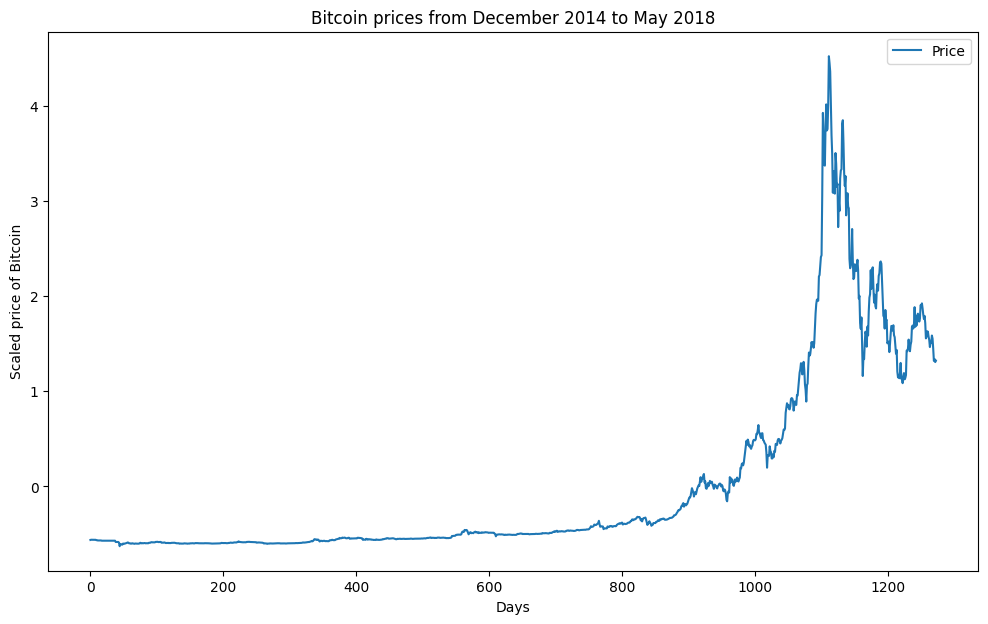

In [27]:
# Plotting the data
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

# Window Size function

In [9]:
def window_data(data, window_size):
    """
    This function is used to create Features and Labels datasets. By windowing the data.

    Input:
    data - dataset used in the project
    window_size - how many data points we are going to use to predict the next datapoint in the sequence

    [Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]

    Outputs:
    X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1]
    y - 'labels', actually this is the next number in the sequence, this number we are trying to predict
    """
    X = []
    y = []

    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

        i += 1
    assert len(X) ==  len(y)
    return X, y

# Splitting the Dataset

In [28]:
# Windowing the data with window_data function
# Splitting into train, val, test sets (80, 20)

window_size = 7
X, y = window_data(scaled_data, window_size)

X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])


X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print(f"X_train size: {X_train.shape}")
print(f"y_train size: {y_train.shape}\n")

print(f"X_test size: {X_test.shape}")
print(f"y_test size: {y_test.shape}\n")

X_train size: (1018, 7, 1)
y_train size: (1018, 1)

X_test size: (248, 7, 1)
y_test size: (248, 1)



# Build Model function

In [29]:
def build_model(batch_size, hidden_layer, learning_rate, window_size):
    """
        Builds LSTM model.
    """
    model = Sequential()
    model.add(LSTM(hidden_layer, batch_input_shape=(batch_size, window_size, 1)))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=MeanSquaredError(), optimizer=optimizer)

    return model

# Experimentations

### Disclaimer

The best parameters for our LSTM model are being searched via grid search, an exhaustive searching method that operates in O(n^parameters). In spite of its slow performance we have the guarantee that among the parameters tested, we are getting to the best.

Our approach was to vary each parameter on its own to observe it's performance impact. Only then, varying all of them to get to best combination.

### The parameters beign varied are:

- batch_size = 32, 64, 128
- hidden_layer = 32, 64, 128, 256, 512
- learning_rate = 0.001, 0.01, 0.1
- epochs = 25, 50, 100, 200

In [30]:
# Sample param_grid argument for GridSearchCV
# Used it as a reference for the following param_grids

"""
param_grid = {
    'batch_size': [32, 64, 128],
    'hidden_layer': [32, 64, 128, 256, 512],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [25]
}
"""

"\nparam_grid = {\n    'batch_size': [32, 64, 128],\n    'hidden_layer': [32, 64, 128, 256, 512],\n    'learning_rate': [0.001, 0.01, 0.1],\n    'epochs': [25]\n}\n"

### Epochs: 25, 50, 100, 200

Presents really strong signals of overfitting

In [32]:
param_grid = {
    'batch_size': [32],
    'hidden_layer': [32],
    'learning_rate': [0.01],
    'epochs': [25, 50, 100, 200],
    'window_size': [7]
}

model = KerasRegressor(build_fn=build_model)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, return_train_score=True)
grid_result = grid.fit(X_train, y_train)

# Printing best results
print(f"\nBest: {grid_result.best_score_} using {grid_result.best_params_}")

<ipython-input-32-8c95ac554114>:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model)


Epoch 1/25
22/22 [==============================] - 3s 4ms/step - loss: 0.0311
Epoch 2/25
22/22 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 3/25
22/22 [==============================] - 0s 4ms/step - loss: 9.4011e-04
Epoch 4/25
22/22 [==============================] - 0s 4ms/step - loss: 7.8992e-04
Epoch 5/25
22/22 [==============================] - 0s 4ms/step - loss: 7.7201e-04
Epoch 6/25
22/22 [==============================] - 0s 4ms/step - loss: 7.4398e-04
Epoch 7/25
22/22 [==============================] - 0s 4ms/step - loss: 7.3863e-04
Epoch 8/25
22/22 [==============================] - 0s 4ms/step - loss: 7.2178e-04
Epoch 9/25
22/22 [==============================] - 0s 4ms/step - loss: 8.0078e-04
Epoch 10/25
22/22 [==============================] - 0s 4ms/step - loss: 7.5983e-04
Epoch 11/25
22/22 [==============================] - 0s 4ms/step - loss: 6.5042e-04
Epoch 12/25
22/22 [==============================] - 0s 4ms/step - loss: 8.2210e-04
Epoch 13/

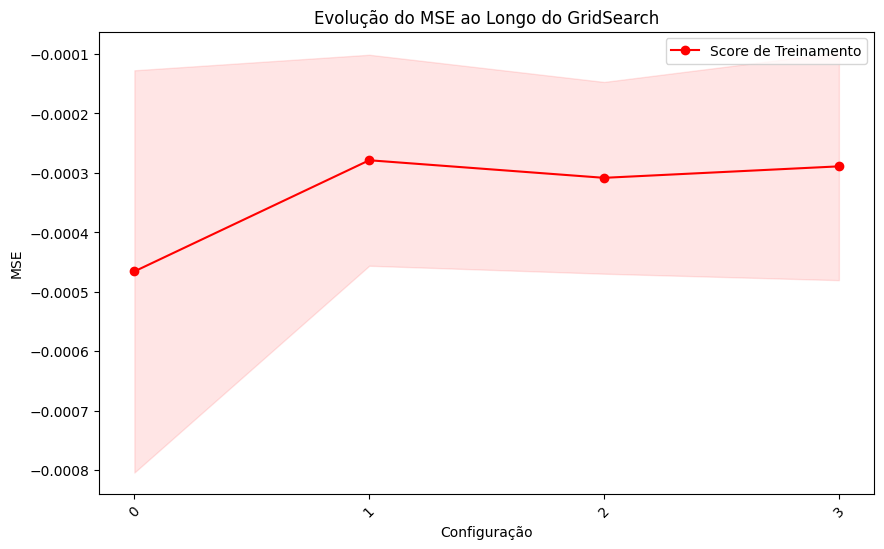

In [33]:
# Visualize the evolution of the metrics along the grid search

# Store validation and training scores for each fold
train_scores_mean = grid_result.cv_results_["mean_train_score"]
train_scores_std = grid_result.cv_results_["std_train_score"]

# Plot medium MSE for trainind and test
plt.figure(figsize=(10, 6))
plt.title("Evolução do MSE ao Longo do GridSearch")
plt.xlabel("Configuração")
plt.ylabel("MSE")
plt.fill_between(range(len(train_scores_mean)), train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_scores_mean, 'o-', color="r", label="Score de Treinamento")
plt.xticks(range(len(train_scores_mean)), rotation=45)
plt.legend(loc="best")
plt.show()

In [34]:
grid_result.best_params_

{'batch_size': 32,
 'epochs': 25,
 'hidden_layer': 32,
 'learning_rate': 0.01,
 'window_size': 7}

In [35]:
# Predict value with trained model
y_pred = grid_result.predict(X_test).flatten()

# Certifying y_test is 1-D
y_test_1d = y_test.flatten()

# Calculate and print MSE
mse = mean_squared_error(y_test_1d, y_pred)
print(f"MSE: {mse}")

# Calculate and print RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Calculate and print COSINE
cosine_similarity = 1 - cosine(y_test_1d, y_pred)
print(f"COSINE: {cosine_similarity}")

8/8 [==============================] - 0s 2ms/step
MSE: 0.21017446651248828
RMSE: 0.458447888546221
COSINE: 0.9943044047834386


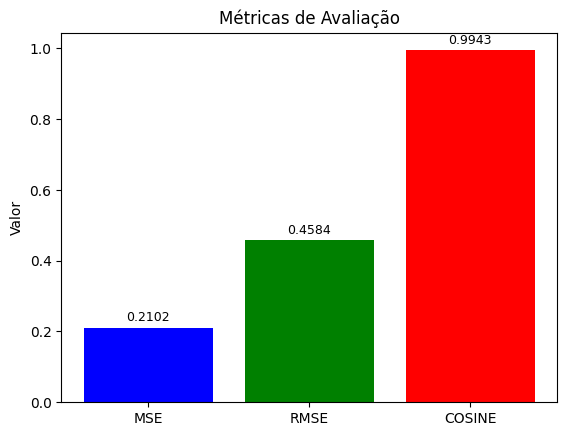

In [36]:
# Visualization
metrics_names = ['MSE', 'RMSE', 'COSINE']
metrics_values = [mse, rmse, cosine_similarity]

plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red'])

# Titles and labels
plt.title("Métricas de Avaliação")
plt.ylabel('Valor')
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.01, "%.4f" % v, ha='center', va='bottom', fontsize=9)

plt.show()

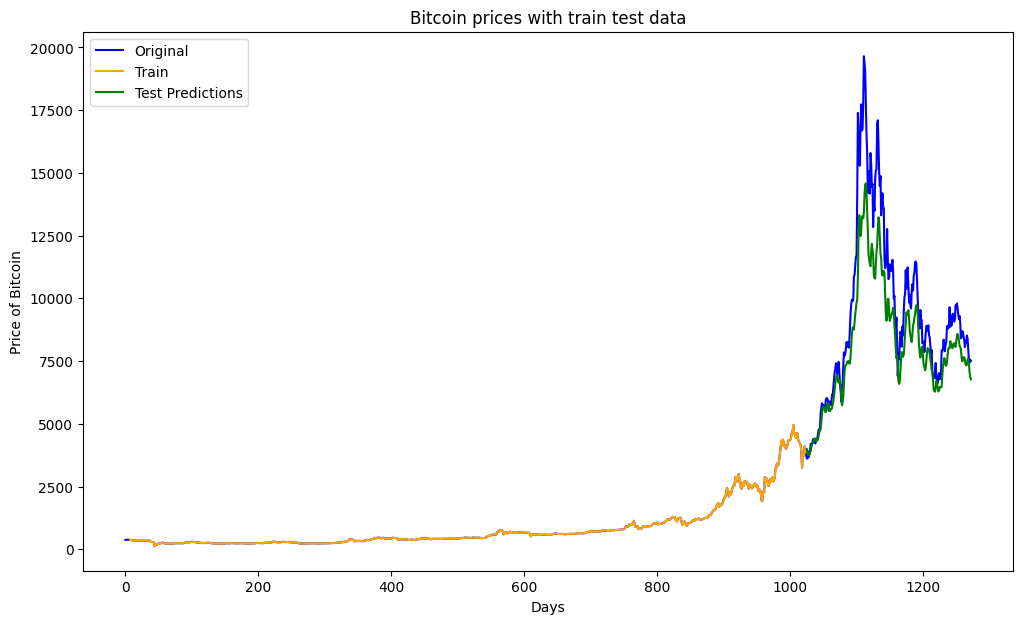

In [39]:
best_model = grid_result.best_estimator_.model
window_size = 7

# Graph creation
plt.figure(figsize=(12,7))

# Inital data plotting
plt.plot(scaler.inverse_transform(scaled_data), color='blue', label='Original')

# Training data plotting
plt.plot(range(window_size, len(X_train) + window_size), scaler.inverse_transform(scaled_data[window_size:len(X_train)+window_size]), color='orange', label='Train')

# Test data plotting
test_start_point = len(X_train) + window_size
test_end_point = test_start_point + len(y_pred)
plt.plot(range(test_start_point, test_end_point), scaler.inverse_transform(y_pred.reshape(-1,1)), color='green', label='Test Predictions')

# Subtitles and show graph
plt.title('Bitcoin prices with train test data')
plt.xlabel('Days')
plt.ylabel('Price of Bitcoin')
plt.legend()
plt.show()

### Batch size: 32, 64, 126, 256

Presents really strong signals of overfitting

In [40]:
param_grid = {
    'batch_size': [32, 64, 128, 256],
    'hidden_layer': [32],
    'learning_rate': [0.01],
    'epochs': [25],
    'window_size': [7]
}

model = KerasRegressor(build_fn=build_model)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, return_train_score=True)
grid_result = grid.fit(X_train, y_train)

# Imprimindo os melhores resultados
print(f"\nBest: {grid_result.best_score_} using {grid_result.best_params_}")


<ipython-input-40-7181946424f2>:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model)


Epoch 1/25
22/22 [==============================] - 3s 6ms/step - loss: 0.0344
Epoch 2/25
22/22 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 3/25
22/22 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 4/25
22/22 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 5/25
22/22 [==============================] - 0s 8ms/step - loss: 7.9455e-04
Epoch 6/25
22/22 [==============================] - 0s 8ms/step - loss: 7.8731e-04
Epoch 7/25
22/22 [==============================] - 0s 8ms/step - loss: 7.4538e-04
Epoch 8/25
22/22 [==============================] - 0s 7ms/step - loss: 7.6244e-04
Epoch 9/25
22/22 [==============================] - 0s 7ms/step - loss: 7.6291e-04
Epoch 10/25
22/22 [==============================] - 0s 9ms/step - loss: 7.4336e-04
Epoch 11/25
22/22 [==============================] - 0s 9ms/step - loss: 8.7416e-04
Epoch 12/25
22/22 [==============================] - 0s 9ms/step - loss: 6.9005e-04
Epoch 13/25
22/2

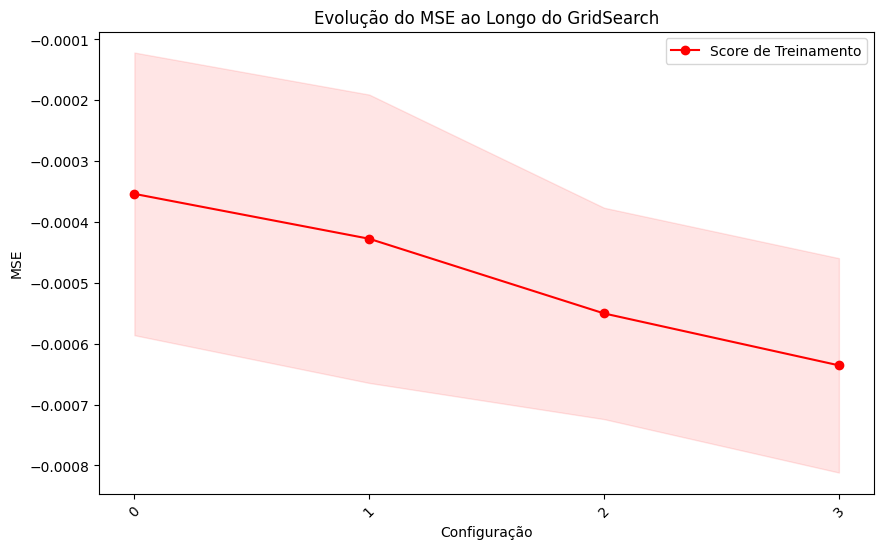

In [41]:
# Visualize the evolution of the metrics along the grid search

# Store validation and training scores for each fold
train_scores_mean = grid_result.cv_results_["mean_train_score"]
train_scores_std = grid_result.cv_results_["std_train_score"]

# Plot medium MSE for trainind and test
plt.figure(figsize=(10, 6))
plt.title("Evolução do MSE ao Longo do GridSearch")
plt.xlabel("Configuração")
plt.ylabel("MSE")
plt.fill_between(range(len(train_scores_mean)), train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_scores_mean, 'o-', color="r", label="Score de Treinamento")
plt.xticks(range(len(train_scores_mean)), rotation=45)
plt.legend(loc="best")
plt.show()

In [21]:
grid_result.best_params_

{'batch_size': 32, 'epochs': 25, 'hidden_layer': 32, 'learning_rate': 0.01}

In [42]:
# Predict value with trained model
y_pred = grid_result.predict(X_test).flatten()

# Certifying y_test is 1-D
y_test_1d = y_test.flatten()

# Calculate and print MSE
mse = mean_squared_error(y_test_1d, y_pred)
print(f"MSE: {mse}")

# Calculate and print RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Calculate and print COSINE
cosine_similarity = 1 - cosine(y_test_1d, y_pred)
print(f"COSINE: {cosine_similarity}")

8/8 [==============================] - 1s 3ms/step
MSE: 0.38353532103239063
RMSE: 0.6193022856670163
COSINE: 0.9932872231292935


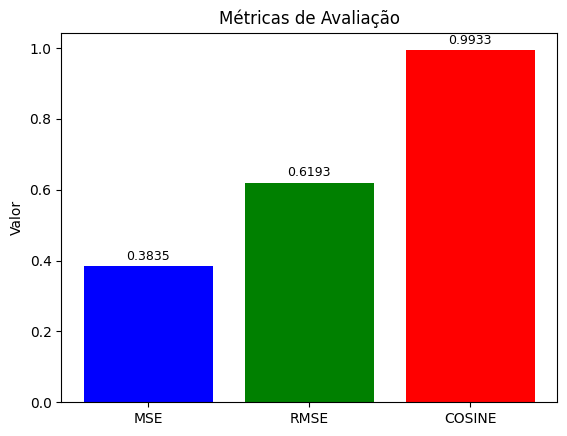

In [43]:
# Visualization
metrics_names = ['MSE', 'RMSE', 'COSINE']
metrics_values = [mse, rmse, cosine_similarity]

plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red'])

# Titles and labels
plt.title("Métricas de Avaliação")
plt.ylabel('Valor')
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.01, "%.4f" % v, ha='center', va='bottom', fontsize=9)

plt.show()

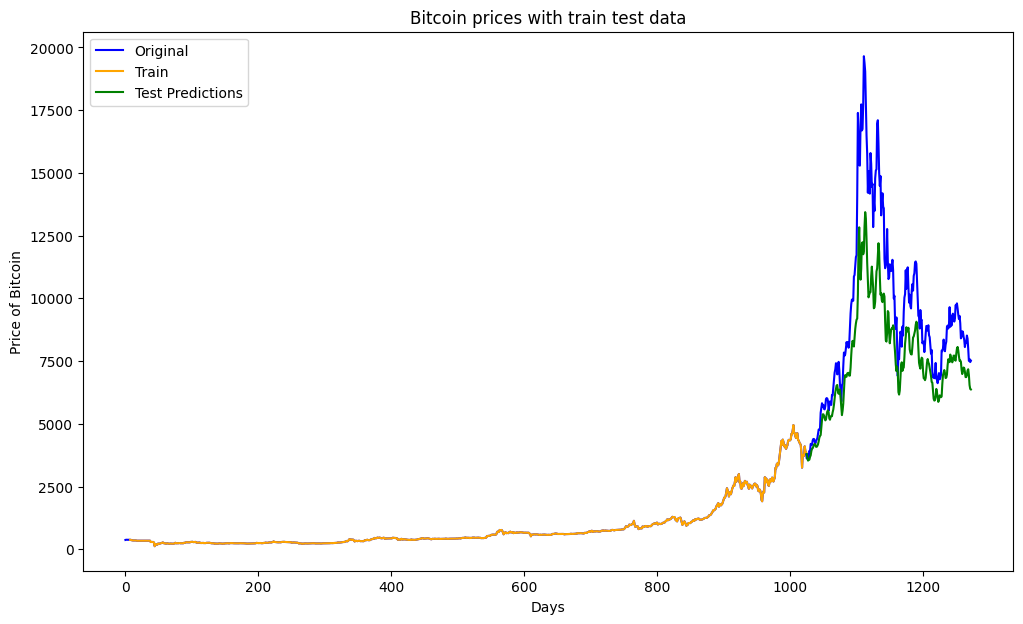

In [44]:
best_model = grid_result.best_estimator_.model
window_size = 7

# Graph creation
plt.figure(figsize=(12,7))

# Inital data plotting
plt.plot(scaler.inverse_transform(scaled_data), color='blue', label='Original')

# Training data plotting
plt.plot(range(window_size, len(X_train) + window_size), scaler.inverse_transform(scaled_data[window_size:len(X_train)+window_size]), color='orange', label='Train')

# Test data plotting
test_start_point = len(X_train) + window_size
test_end_point = test_start_point + len(y_pred)
plt.plot(range(test_start_point, test_end_point), scaler.inverse_transform(y_pred.reshape(-1,1)), color='green', label='Test Predictions')

# Subtitles and show graph
plt.title('Bitcoin prices with train test data')
plt.xlabel('Days')
plt.ylabel('Price of Bitcoin')
plt.legend()
plt.show()

### Window Size :

### Clip Margin